In [72]:
dependencies = [
    "fastai",
    "nbdev",
]

!pip install -U {" ".join(dependencies)}

In [114]:
import gc

from fastai.imports import *
import torch
from fastai.collab import *
from fastai.tabular.all import *

import matplotlib.pyplot as plt

In [74]:
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [75]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [76]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [77]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,715,"Empire Strikes Back, The (1980)",4
1,676,Amistad (1997),4
2,334,Babe (1995),4
3,468,Independence Day (ID4) (1996),4
4,130,"Firm, The (1993)",5
5,363,"Unbearable Lightness of Being, The (1988)",1
6,119,Home for the Holidays (1995),5
7,894,Breakdown (1997),3
8,883,Forget Paris (1995),3
9,897,"Magnificent Seven, The (1954)",3


In [78]:
x,y = dls.one_batch()
x.shape, y.shape
y

tensor([[4],
        [3],
        [3],
        [5],
        [3],
        [4],
        [4],
        [4],
        [5],
        [3],
        [3],
        [2],
        [4],
        [4],
        [2],
        [4],
        [2],
        [5],
        [3],
        [2],
        [2],
        [4],
        [3],
        [4],
        [5],
        [4],
        [4],
        [3],
        [5],
        [4],
        [4],
        [5],
        [3],
        [5],
        [5],
        [5],
        [3],
        [4],
        [2],
        [5],
        [4],
        [5],
        [1],
        [3],
        [3],
        [1],
        [3],
        [2],
        [3],
        [3],
        [4],
        [4],
        [1],
        [4],
        [4],
        [4],
        [4],
        [5],
        [2],
        [3],
        [4],
        [4],
        [4],
        [3]], dtype=torch.int8)

In [79]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [80]:
user_factors.shape

torch.Size([944, 5])

In [81]:
user_factors[3]

tensor([ 0.4257, -0.1320, -0.0086, -0.1266,  0.8826])

In [82]:
# create an array of zeroes * n_users
# mark a 1 at index 3
one_hot_3 = one_hot(3, n_users).float()
one_hot_3

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [83]:
# multiplying by the one_hot encoding is the same as applying a filter
user_factors.t() @ one_hot_3

tensor([ 0.4257, -0.1320, -0.0086, -0.1266,  0.8826])

In [84]:
# which is the same as index lookup
user_factors[3]

tensor([ 0.4257, -0.1320, -0.0086, -0.1266,  0.8826])

In [85]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_Factors = Embedding(n_movies, n_factors)

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.user_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [86]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [87]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,6.654263,6.931840,00:05
1,6.830277,6.886321,00:05
2,6.685863,6.842107,00:05
3,6.779932,6.784038,00:05
4,6.561185,6.769599,00:04


In [88]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [89]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.942171,1.005720,00:06
1,0.647706,0.933263,00:06
2,0.463986,0.941729,00:06
3,0.366823,0.942177,00:07
4,0.342851,0.941436,00:07


In [90]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [91]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)


epoch,train_loss,valid_loss,time
0,0.873882,0.938154,00:10
1,0.570295,0.910249,00:10
2,0.393676,0.931830,00:09
3,0.325368,0.940910,00:09
4,0.305473,0.941943,00:08




Instead of being better, it ends up being worse (at least at the end of training). Why is that? If we look at both trainings carefully, we can see the validation loss stopped improving in the middle and started to get worse. As we've seen, this is a clear indication of overfitting. In this case, there is no way to use data augmentation, so we will have to use another regularization technique. One approach that can be helpful is weight decay.


### Weight Decay

In [92]:
# loss_with_wd = loss + wd * (parameters**2).sum()

In [93]:
# parameters.grad += wd * 2 * parameters

In [94]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.905125,0.946374,00:09
1,0.686770,0.888966,00:08
2,0.515387,0.868627,00:08
3,0.444194,0.852868,00:08
4,0.437660,0.848779,00:08


### What's an Embedding?

In [95]:
Embedding??

Init signature: Embedding(ni, nf, std=0.01)
Source:        
class Embedding(nn.Embedding):
    "Embedding layer with truncated normal initialization"
    def __init__(self, ni, nf, std=0.01):
        super().__init__(ni, nf)
        trunc_normal_(self.weight.data, std=std)
File:           ~/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/layers.py
Type:           type
Subclasses:     

In [96]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [97]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [98]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.5582],
        [-0.7397],
        [-0.3363]], requires_grad=True)]

In [99]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [100]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))
    # return nn.Parameter(torch.randn(size) * 0.005 + 0.005)

In [118]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [119]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.887831,0.950890,00:08
1,0.680856,0.885827,00:09
2,0.516147,0.865423,00:08
3,0.437043,0.854344,00:08
4,0.430565,0.850546,00:08


### Interpreting Embeddings and Biases

In [120]:
# Create a tensor with dimensions of size 1
tensor = torch.tensor([[1], [2], [3]])

print(tensor.size())  # Output: torch.Size([3, 1])

# Remove dimensions of size 1 using squeeze()
squeezed_tensor = tensor.squeeze()

print(squeezed_tensor.size())  # Output: torch.Size([3])

torch.Size([3, 1])
torch.Size([3])


In [121]:
movie_biases = learn.model.movie_bias.squeeze()
movie_biases.shape, movie_biases

(torch.Size([1665]),
 tensor([ 0.0001, -0.0903,  0.0305,  ..., -0.0156,  0.0652,  0.0197],
        device='mps:0', grad_fn=<SqueezeBackward0>))

In [122]:
idxs = movie_biases.argsort()[:5]
idxs

tensor([ 295,  633, 1378,  850,  256], device='mps:0')

In [123]:
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Grease 2 (1982)',
 'Spice World (1997)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Cable Guy, The (1996)']

In [124]:
idxs = movie_biases.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Titanic (1997)',
 'Rear Window (1954)',
 "Schindler's List (1993)"]

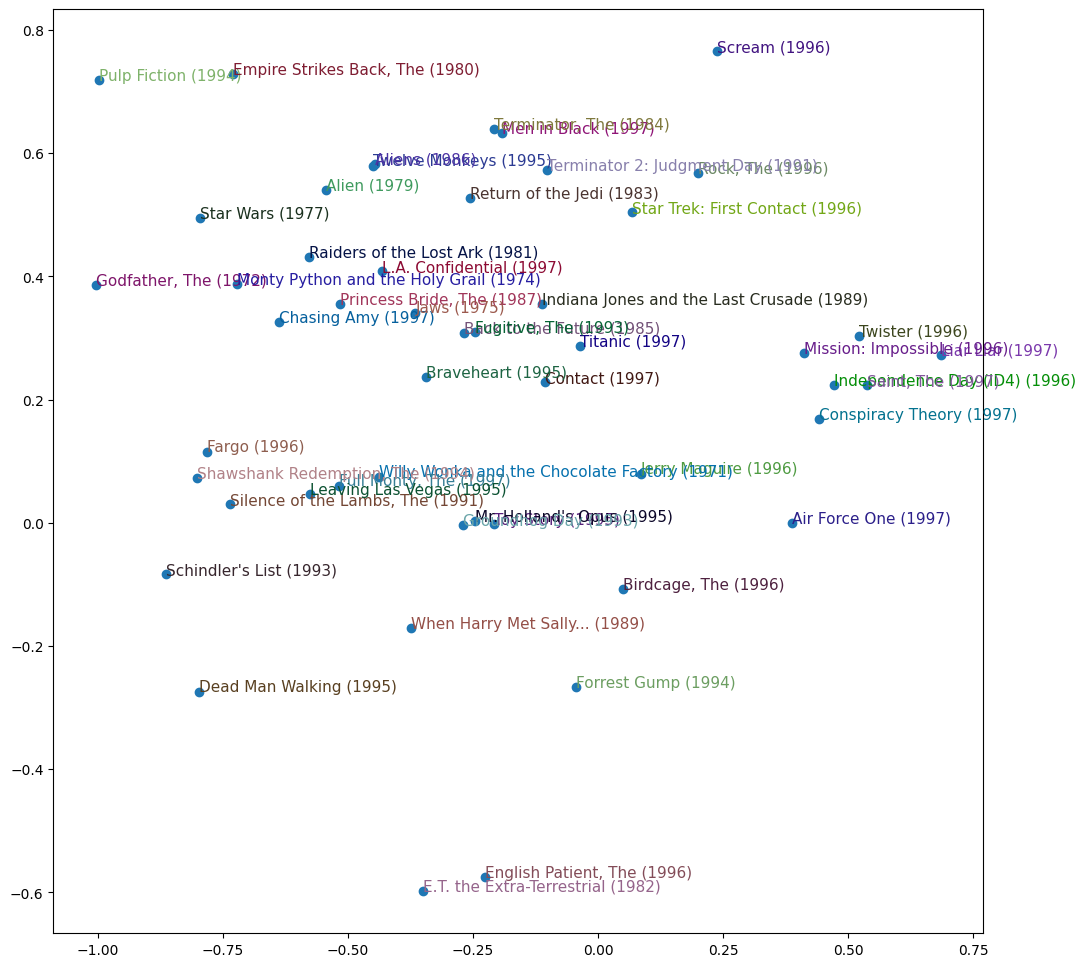

In [126]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = torch.tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()

movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Fastai

In [133]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.870387,0.948209,00:08
1,0.691614,0.893102,00:08
2,0.537893,0.866842,00:08
3,0.483752,0.849322,00:09
4,0.439566,0.845406,00:09


In [134]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [135]:
EmbeddingDotBias??

Init signature: EmbeddingDotBias(n_factors, n_users, n_items, y_range=None)
Source:        
class EmbeddingDotBias(Module):
    "Base dot model for collaborative filtering."
    def __init__(self, n_factors, n_users, n_items, y_range=None):
        self.y_range = y_range
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [Embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, x):
        users,items = x[:,0],x[:,1]
        dot = self.u_weight(users)* self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]

    @classmethod
    def from_classes(cls, n_factors, classes, user=None, item=None, y_range=None):
        "Build a model with `n_factors` by inferring `n_users` and  `n_items` from `classes`"
        i

In [137]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'L.A. Confidential (1997)',
 'As Good As It Gets (1997)',
 'Titanic (1997)']

### Getting Similar Movies With Embedding Distance

In [147]:
dls.classes['title'].o2i

defaultdict(int,
            {'#na#': 0,
             "'Til There Was You (1997)": 1,
             '1-900 (1994)': 2,
             '101 Dalmatians (1996)': 3,
             '12 Angry Men (1957)': 4,
             '187 (1997)': 5,
             '2 Days in the Valley (1996)': 6,
             '20,000 Leagues Under the Sea (1954)': 7,
             '2001: A Space Odyssey (1968)': 8,
             '3 Ninjas: High Noon At Mega Mountain (1998)': 9,
             '39 Steps, The (1935)': 10,
             '8 1/2 (1963)': 11,
             '8 Heads in a Duffel Bag (1997)': 12,
             '8 Seconds (1994)': 13,
             'A Chef in Love (1996)': 14,
             'Above the Rim (1994)': 15,
             'Absolute Power (1997)': 16,
             'Abyss, The (1989)': 17,
             'Ace Ventura: Pet Detective (1994)': 18,
             'Ace Ventura: When Nature Calls (1995)': 19,
             'Across the Sea of Time (1995)': 20,
             'Addams Family Values (1993)': 21,
             'Addicted t

In [152]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i["Mission: Impossible (1996)"]
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[:5]
dls.classes['title'][idx]


(#5) ['Mission: Impossible (1996)','GoldenEye (1995)','Crimson Tide (1995)','In the Line of Fire (1993)','Kull the Conqueror (1997)']

# Deep Learning for Collaborative Filtering

In [154]:
get_emb_sz??

Signature: get_emb_sz(to: 'Tabular | TabularPandas', sz_dict: 'dict' = None) -> 'list'
Source:   
def get_emb_sz(
    to:Tabular|TabularPandas, 
    sz_dict:dict=None # Dictionary of {'class_name' : size, ...} to override default `emb_sz_rule` 
) -> list: # List of embedding sizes for each category
    "Get embedding size for each cat_name in `Tabular` or `TabularPandas`, or populate embedding size manually using sz_dict"
    return [_one_emb_sz(to.classes, n, sz_dict) for n in to.cat_names]
File:      ~/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/tabular/model.py
Type:      function

In [153]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [155]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [156]:
model = CollabNN(*embs)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.937473,0.955399,00:11
1,0.833789,0.903189,00:10
2,0.820390,0.890459,00:10
3,0.786251,0.869594,00:10
4,0.752508,0.863848,00:10


In [157]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.984234,0.978775,00:15
1,0.902135,0.914950,00:14
2,0.833911,0.887844,00:16
3,0.762101,0.870414,00:15
4,0.755031,0.858330,00:14


In [158]:
EmbeddingNN??

Init signature:
EmbeddingNN(
    emb_szs,
    layers,
    *,
    ps: 'float | MutableSequence' = None,
    embed_p: 'float' = 0.0,
    y_range=None,
    use_bn: 'bool' = True,
    bn_final: 'bool' = False,
    bn_cont: 'bool' = True,
    act_cls=ReLU(inplace=True),
    lin_first: 'bool' = True,
)
Source:        
class EmbeddingNN(TabularModel):
    "Subclass `TabularModel` to create a NN suitable for collaborative filtering."
    @delegates(TabularModel.__init__)
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs=emb_szs, n_cont=0, out_sz=1, layers=layers, **kwargs)
File:           ~/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/collab.py
Type:           PrePostInitMeta
Subclasses:     

In [163]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50,50,50])
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=176, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): LinBnDrop(
      (0): Linear(in_features=50, out_features=50, bias=False)
      (1): ReLU(inplace=

In [ ]:
learn.lr_find()

In [162]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.966965,0.979760,00:20
1,0.866298,0.932207,00:20
2,0.813896,0.899229,00:20
3,0.785918,0.871896,00:20
4,0.733155,0.867148,00:20
